# Performing normality tests
## Import libraries

In [1]:
from pandas_datareader import data
import numpy as np
import matplotlib.pyplot as plt
import statistics as stat
from scipy.stats import shapiro
from scipy.stats import normaltest
from scipy.stats import anderson
from scipy import stats
from scipy.stats.mstats import gmean
import pandas as pd
import time
import seaborn as sns

## Normal distribution measurements

#### - Peak: refers to the count of instances where log returns are between +- 0.80 between the mean and standard deviation
#### - Up_fac: refers to the number of standard deviations away from the mean at the 85th percentile
#### - Down_fac: refers to the number of standard deviations away from the mean at the 15th percentile
#### - Choosing the 15th to 85th percentile captures 70% of log normal returns in the normal distribution, 15% above the 85th percentile will be the selling trigger and 15% below the 15th percentile will be the buying trigger

Average number of samples +- 0.80 between mn and std: 69.41336633663366
Number of std away from mn at 85th percentile: 0.7978526930352552
Number of std away from mn at 15th percentile: -0.835745197332897
                 High        Low       Open      Close      Volume  Adj Close  \
Date                                                                            
2017-07-31  54.680000  53.950001  54.480000  53.980000  20299400.0  51.536572   
2017-08-01  54.790001  53.970001  54.570000  54.730000  18120900.0  52.252621   
2017-08-02  55.450001  54.669998  54.750000  55.430000  14764900.0  52.920937   
2017-08-03  56.119999  55.500000  55.639999  55.680000  13331500.0  53.159622   
2017-08-04  56.049999  55.090000  55.970001  55.439999   9179800.0  52.930481   
2017-08-07  55.930000  55.419998  55.599998  55.630001   7253900.0  53.111885   
2017-08-08  55.580002  54.360001  55.549999  54.520000  11095300.0  52.287102   
2017-08-09  54.430000  53.299999  54.430000  53.740002  16717700.0 

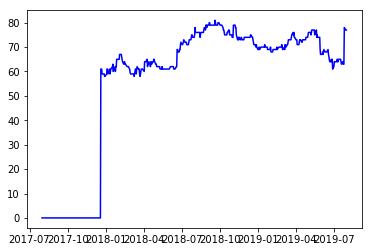

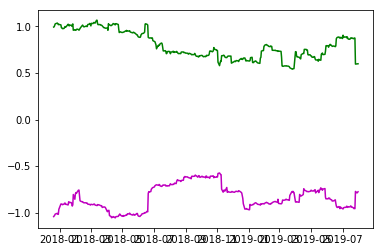

In [3]:
df = data.get_data_yahoo('SBUX', '2017-08-01', '2019-07-31')
df['lg_returns'] = [0]+[(np.log(j) - np.log(df.iloc[i-1,5]))for i,j in enumerate(df['Adj Close']) if i != 0]
df['mean'] = df.lg_returns.rolling(100).mean()
df['std'] = df.lg_returns.rolling(100).std()

peak = []
for i,j in enumerate(df.lg_returns):
    mn = df.iloc[i,7]
    sd = df.iloc[i,8]
    count = 0
    try:
        for r in range(0,100):
            n = df.iloc[i-r,6]
            if (n >(mn-0.80*sd) and n < (mn+0.80*sd)):
                count +=1
    except:
        count=0
    peak.append(count)
df['peak'] = peak

up_fac = []
down_fac = []
for i,j in enumerate(df.lg_returns):
    mn = df.iloc[i,7]
    sd = df.iloc[i,8]
    try:
        x = [df.iloc[i-r,6] for r in range(0,100)]
        x = np.array(x)
        q1_x = np.quantile(x, 0.15, interpolation='midpoint')
        q3_x = np.quantile(x, 0.85, interpolation='midpoint')
        up = (q3_x - mn)/sd
        down = (q1_x - mn)/sd
    except:
        up = 0
        down = 0
    up_fac.append(up)
    down_fac.append(down)
df['up_fac'] = up_fac
df['down_fac'] = down_fac
    
# df['upper_cdf'] = [stats.norm(i, j).cdf(i+j) for i,j in zip(df['mean'], df['std'])]
# df['lower_cdf'] = [stats.norm(i, j).cdf(i-j) for i,j in zip(df['mean'], df['std'])]
# df['peak_cdf'] = [i-j for i,j in zip(df['upper_cdf'], df['lower_cdf'])]
print('Average number of samples +- 0.80 between mn and std: {}'.format(sum(df.peak)/(len(df.peak)-100)))
print('Number of std away from mn at 85th percentile: {}'.format(sum(up_fac[99:]) / len(up_fac[99:])))
print('Number of std away from mn at 15th percentile: {}'.format(sum(down_fac[99:]) / len(down_fac[99:])))
print(df.head(120))

plt.plot(df.index, df.peak,color='b',label='peak')
plt.show()
plt.plot(df.index, df.up_fac,color='g',label='up')
plt.plot(df.index, df.down_fac,color='m',label='down')
plt.show()

# Creating class object for strategy

## Strategy OOP - Draft
#### - Strategy is to buy when log returns are below the trigger point of (mean - 1 * standard deviation) and sell when log returns are above the trigger point of (mean + 1 * standard deviation)
#### - Strategy allows user to choose the number of rolling days / moving average days for mean and standard deviation (naturally a lower number of days would mean more frequent trading)
#### - Strategy enables a plotting function of buys and sells over the time period and also a table of features relating to the buys and sells
#### - I honestly later found out that this strategy I have thought out is literally similar to the Bollinger Bands Trading Strategy

In [5]:
class DraftStrat(object):
    def __init__(self, start_cash, ticker, start_date, end_date, period):
        self.start_cash = start_cash
        self.ticker = ticker
        self.start_date = start_date
        self.end_date = end_date
        self.period = period
        self._reset_values()

    def _reset_values(self):
        self.data = pd.DataFrame()
        self.position = 0
        self.buy_position = {} 
        self.sell_position = {}
        self.buy_data = pd.DataFrame()
        self.sell_data = pd.DataFrame()
        self.df = pd.DataFrame()

    def _run_strat(self):
        df = data.get_data_yahoo(self.ticker, self.start_date, self.end_date)
        df['lg_returns'] = [0]+[(np.log(j) - np.log(df.iloc[i - 1, 5])) for i, j in enumerate(df['Adj Close']) if i != 0]
        df['buy'] = df.lg_returns.rolling(self.period).mean() - df.lg_returns.rolling(self.period).std()
        df['sell'] = df.lg_returns.rolling(self.period).mean() + df.lg_returns.rolling(self.period).std()
        self.data = df

        for i in range(self.period,len(self.data)):
            # 6,7,8 is returns, buy, sell
            if self.position == 0:
                if self.data.iloc[i,6] < self.data.iloc[i-1,7]:
                    self.position +=1
                    self.buy_position.update({self.data.index[i]:self.data.iloc[i,5]})
                    self.start_cash -= self.data.iloc[i,5]*100
                    self.buy_data = self.buy_data.append(
                                {'Symbol': self.ticker, 'Buy_Date': self.data.index[i],
                                 'Buy_Price': self.data.iloc[i,5],
                                 'Buy_Mean':self.data.iloc[(i-self.period):i,6].mean(), 
                                 'Buy_Stdev':self.data.iloc[(i-self.period):i,6].std(), 
                                 'Buy_lgret':self.data.iloc[i,6],
                                 'Buy_Trigger':self.data.iloc[i-1,7]}, 
                                ignore_index=True)
            else:
                if self.data.iloc[i,6] > self.data.iloc[i-1,8]:
                    self.position -=1
                    self.sell_position.update({self.data.index[i]:self.data.iloc[i,5]})
                    self.start_cash += self.data.iloc[i,5]*100
                    self.sell_data = self.sell_data.append(
                                {'Sell_Date': self.data.index[i],'Sell_Price': self.data.iloc[i,5],
                                 'Sell_Mean':self.data.iloc[(i-self.period):i,6].mean(), 
                                 'Sell_Stdev':self.data.iloc[(i-self.period):i,6].std(), 
                                 'Sell_lgret':self.data.iloc[i,6],
                                 'Sell_Trigger':self.data.iloc[i-1,8]}, 
                                ignore_index=True)
        return self
    
    def _plot(self):
        plt.figure(figsize=(15,7.5))
        plt.scatter(self.buy_position.keys(), self.buy_position.values(), color='g', marker='^')
        plt.scatter(self.sell_position.keys(), self.sell_position.values(), color='r', marker='v')
        plt.plot(self.data.index, self.data['Adj Close'], color='b', alpha=0.3)
        return self
    
    def _return_stats(self):
        self.df = pd.concat([self.buy_data, self.sell_data], axis=1)
        self.df['Days_lapse'] = self.df['Sell_Date'] - self.df['Buy_Date']
        self.df['Profit'] = self.df['Sell_Price'] - self.df['Buy_Price']
        return self

33.44227600097656


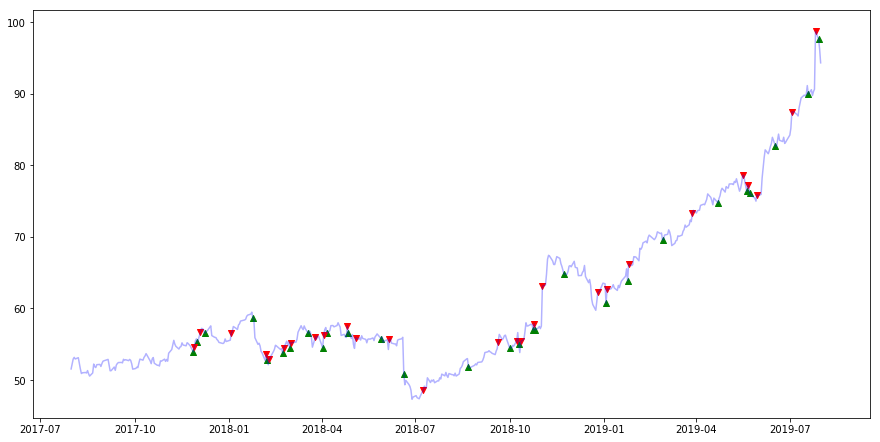

In [15]:
obj = DraftStrat(10000,'SBUX', '2017-08-01', '2019-07-31',75)
obj._run_strat()
obj._plot()
obj._return_stats()
print(np.nansum(obj.df.Profit))

## Strategy OOP - First Test
#### - One major improvement is letting the user decide what is the factor x to be used in deciding the buy and sell triggers, i.e. (mn - x * std) and (mn + x * std)
#### - Another major additon is the strat eff function that provides a snapshot of the strategy picked out, i.e. comparison of strategy returns to returns of a typical buy-hold strategy, reflection of the number of trades made (considering cost to trade) and reflection of the key parameters used like rolling days and factor x

In [7]:
from pandas_datareader import data

class MyStrat(object):
    def __init__(self, start_cash, ticker, start_date, end_date, period, x):
        self.start_cash = start_cash
        self.ticker = ticker
        self.start_date = start_date
        self.end_date = end_date
        self.period = period
        self.fac = x
        self._reset_values()

    def _reset_values(self):
        self.data = pd.DataFrame()
        self.position = 0
        self.buy_position = {} 
        self.sell_position = {}
        self.buy_data = pd.DataFrame()
        self.sell_data = pd.DataFrame()
        self.df = pd.DataFrame()

    def _run_strat(self):
        df = data.get_data_yahoo(self.ticker, self.start_date, self.end_date)
        df['lg_returns'] = [0]+[(np.log(j) - np.log(df.iloc[i - 1, 5])) for i, j in enumerate(df['Adj Close']) if i != 0]
        df['buy'] = df.lg_returns.rolling(self.period).mean() - self.fac*df.lg_returns.rolling(self.period).std()
        df['sell'] = df.lg_returns.rolling(self.period).mean() + self.fac*df.lg_returns.rolling(self.period).std()
        self.data = df

        for i in range(self.period,len(self.data)):
            # 6,7,8 is returns, buy, sell
            if self.position == 0:
                if self.data.iloc[i,6] < self.data.iloc[i-1,7]:
                    self.position +=1
                    self.buy_position.update({self.data.index[i]:self.data.iloc[i,5]})
                    self.start_cash -= self.data.iloc[i,5]*100
                    self.buy_data = self.buy_data.append(
                                {'Symbol': self.ticker, 'Buy_Date': self.data.index[i],
                                 'Buy_Price': self.data.iloc[i,5],
                                 'Buy_Mean':self.data.iloc[(i-self.period):i,6].mean(), 
                                 'Buy_Stdev':self.data.iloc[(i-self.period):i,6].std(), 
                                 'Buy_lgret':self.data.iloc[i,6],
                                 'Buy_Trigger':self.data.iloc[i-1,7]}, 
                                ignore_index=True)
            else:
                if self.data.iloc[i,6] > self.data.iloc[i-1,8]:
                    self.position -=1
                    self.sell_position.update({self.data.index[i]:self.data.iloc[i,5]})
                    self.start_cash += self.data.iloc[i,5]*100
                    self.sell_data = self.sell_data.append(
                                {'Sell_Date': self.data.index[i],'Sell_Price': self.data.iloc[i,5],
                                 'Sell_Mean':self.data.iloc[(i-self.period):i,6].mean(), 
                                 'Sell_Stdev':self.data.iloc[(i-self.period):i,6].std(), 
                                 'Sell_lgret':self.data.iloc[i,6],
                                 'Sell_Trigger':self.data.iloc[i-1,8]}, 
                                ignore_index=True)
        return self
    
    def _plot(self):
        plt.figure(figsize=(15,7.5))
        plt.scatter(self.buy_position.keys(), self.buy_position.values(), color='g', marker='^')
        plt.scatter(self.sell_position.keys(), self.sell_position.values(), color='r', marker='v')
        plt.plot(self.data.index, self.data['Adj Close'], color='b', alpha=0.3)
        return self
    
    def _return_stats(self):
        self.df = pd.concat([self.buy_data, self.sell_data], axis=1)
        self.df['Days_lapse'] = self.df['Sell_Date'] - self.df['Buy_Date']
        self.df['Profit'] = self.df['Sell_Price'] - self.df['Buy_Price']
        return self
    
    def _strat_eff(self):
        bh_gain = (self.data.iloc[len(self.data)-1,5] - self.df.iloc[0,2])*100
        strat_gain = (np.nansum(self.df.Profit))*100
        print("{} start cash | buy-hold return {:.2f}% | strat return {:.2f}%"
              .format(10000, np.log((10000+bh_gain)/10000)*100, np.log((10000+strat_gain)/10000)*100))
        print("{} buys | {} sells" .format(len(self.df['Buy_Date']), len(self.df['Sell_Date'])))
        print("{} rolling days | factor {} to stdev".format(self.period, self.fac))

10000 start cash | buy-hold return 33.95% | strat return 27.89%
36 buys | 36 sells
75 rolling days | factor 0.8 to stdev
32.17048263549805


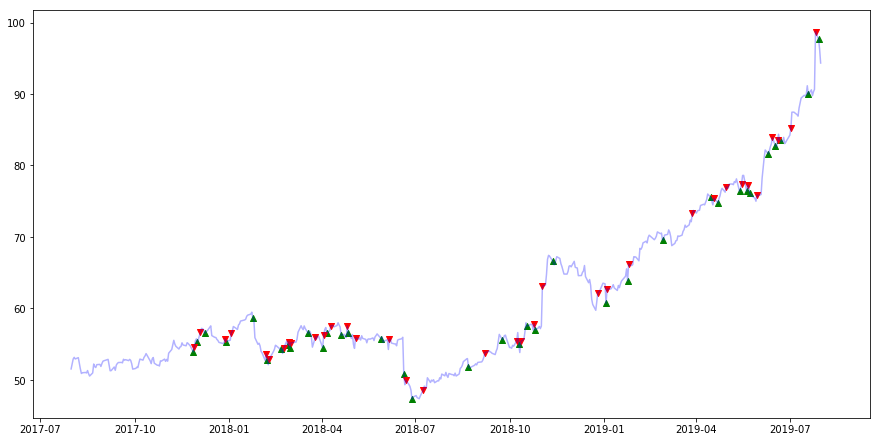

In [16]:
obj = MyStrat(10000,'SBUX', '2017-08-01', '2019-07-31',75,0.80)
obj._run_strat()
obj._plot()
obj._return_stats()
obj._strat_eff()
print(np.nansum(obj.df.Profit))

## Deciding on optimal parameters
#### - The user has to decide on the ideal number of rolling days and the ideal factor x, maybe out of thin air
#### - To know what a good number of rolling days and a good number of factor x should be chosen, this graphing tool visualises the relationship of how rolling days and factor x would impact strategy returns for a particular stock
#### - Every stock actually has a different set of optimised parameters to achieve the highest returns, but a general observation would be that the higher the factor x, the lower the returns
#### - From testing various sets of parameters on historical data, the user can now decide which set is the most optimised

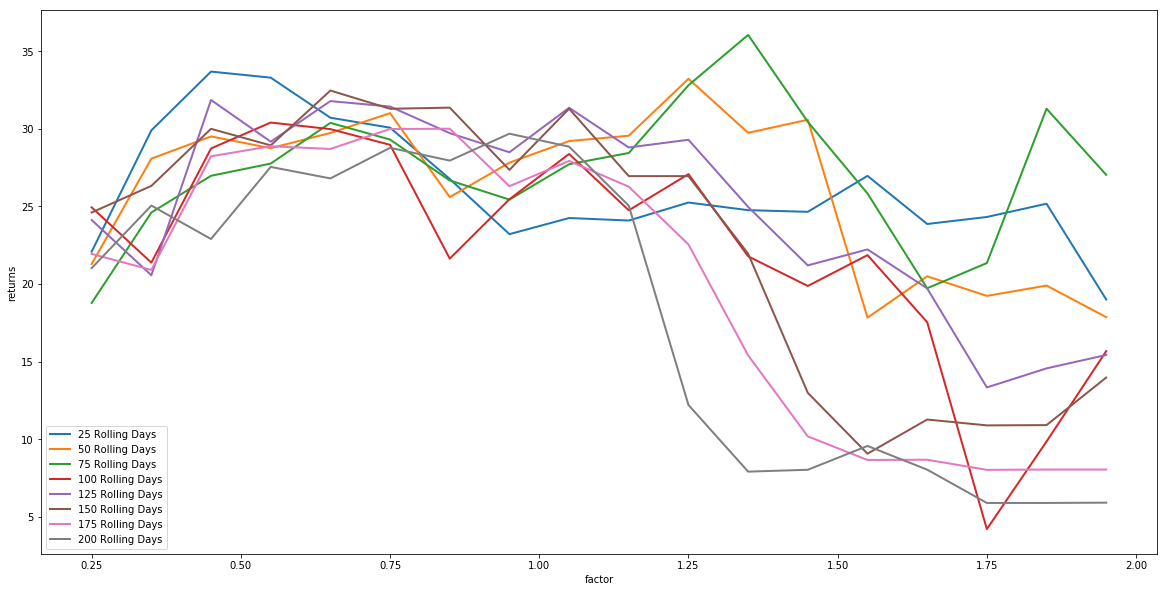

In [9]:
from pandas_datareader import data
import itertools

param_plot = pd.DataFrame()

for i,j in itertools.product(range(25,225,25), np.arange(0.25,2.0,0.1)):
    ttt = MyStrat(10000,'SBUX', '2017-08-01', '2019-07-31',i,j)
    ttt._run_strat()
    ttt._return_stats()
    strat_gain = (np.nansum(ttt.df.Profit))*100
    ret = np.log((10000+strat_gain)/10000)*100
    entry = {'rolling':i, 'factor':j, 'return':ret}
    param_plot = param_plot.append(entry,ignore_index=True)
    
plt.figure(figsize=(20,10))
for i in range(25,225,25):
    pp = param_plot[param_plot['rolling'] == i]
    plt.plot(pp['factor'], pp['return'], label='{} Rolling Days'.format(i),linewidth=2)
    plt.legend(loc='best')
    plt.xlabel('factor')
    plt.ylabel('returns')

## Strategy OOP - Second Test
#### - The major upgrade here is that factor x i.e. (mn - x * std) and (mn + x * std), is now a parameter on a rolling and changing basis instead of a fixed value throughout the strategy timeframe
#### - This uses the normal distribution measurements set out above, where we find the 15th and 85th percentile to be factor x for buy and sell triggers respectively
#### - The advantage is that factor x is not a generalisation or based on the standardardised normal distribution curves. Now factor x is entirely based on how the log normal returns for that particular stock is distributed
#### - The result is that the user does not have to pick out factor x (which may change over time) but would still arrive at a strategy return that is fairly close to the buy-hold strategy returns

In [20]:
from pandas_datareader import data

class NwStrat(object):
    def __init__(self, start_cash, ticker, start_date, end_date, period):
        self.start_cash = start_cash
        self.ticker = ticker
        self.start_date = start_date
        self.end_date = end_date
        self.period = period
        self._reset_values()

    def _reset_values(self):
        self.data = pd.DataFrame()
        self.position = 0
        self.buy_position = {} 
        self.sell_position = {}
        self.buy_data = pd.DataFrame()
        self.sell_data = pd.DataFrame()
        self.df = pd.DataFrame()

    def _processing(self):
        df = data.get_data_yahoo(self.ticker, self.start_date, self.end_date)
        df['lg_returns'] = [0]+[(np.log(j) - np.log(df.iloc[i - 1, 5])) for i, j in enumerate(df['Adj Close']) if i != 0]
        df['mean'] = df.lg_returns.rolling(self.period).mean()
        df['stdev'] = df.lg_returns.rolling(self.period).std()
        self.data = df

        up_fac = []
        down_fac = []
        for i,j in enumerate(self.data.lg_returns):
            mn = self.data.iloc[i,7]
            sd = self.data.iloc[i,8]
            try:
                x = [self.data.iloc[i-r,6] for r in range(0,100)]
                x = np.array(x)
                q1_x = np.quantile(x, 0.15, interpolation='midpoint')
                q3_x = np.quantile(x, 0.85, interpolation='midpoint')
                up = (q3_x - mn)/sd
                down = (q1_x - mn)/sd
            except:
                up = 0
                down = 0
            up_fac.append(up)
            down_fac.append(down)
        self.data['up_fac'] = up_fac
        self.data['down_fac'] = down_fac
        
        self.data['buy'] = [(i + (j*h)) for (i,j,h) in zip(self.data['mean'], self.data['down_fac'], self.data['stdev'])]
        self.data['sell'] = [(i + (j*h)) for (i,j,h) in zip(self.data['mean'], self.data['up_fac'], self.data['stdev'])]
        
    def _run_strat(self):
        for i in range(self.period,len(self.data)):
            # 6,7,8 is returns, mean, stdev
            # 9,10,11,12 is up, down, buy, sell
            if self.position == 0:
                if self.data.iloc[i,6] < self.data.iloc[i-1,11]:
                    self.position +=1
                    self.buy_position.update({self.data.index[i]:self.data.iloc[i,5]})
                    self.start_cash -= self.data.iloc[i,5]*100
                    self.buy_data = self.buy_data.append(
                                {'Symbol': self.ticker, 'Buy_Date': self.data.index[i],
                                 'Buy_Price': self.data.iloc[i,5],
                                 'Buy_Mean':self.data.iloc[(i-self.period):i,6].mean(), 
                                 'Buy_Stdev':self.data.iloc[(i-self.period):i,6].std(), 
                                 'Buy_lgret':self.data.iloc[i,6],
                                 'Buy_Trigger':self.data.iloc[i-1,11]}, 
                                ignore_index=True)
            else:
                if self.data.iloc[i,6] > self.data.iloc[i-1,12]:
                    self.position -=1
                    self.sell_position.update({self.data.index[i]:self.data.iloc[i,5]})
                    self.start_cash += self.data.iloc[i,5]*100
                    self.sell_data = self.sell_data.append(
                                {'Sell_Date': self.data.index[i],'Sell_Price': self.data.iloc[i,5],
                                 'Sell_Mean':self.data.iloc[(i-self.period):i,6].mean(), 
                                 'Sell_Stdev':self.data.iloc[(i-self.period):i,6].std(), 
                                 'Sell_lgret':self.data.iloc[i,6],
                                 'Sell_Trigger':self.data.iloc[i-1,12]}, 
                                ignore_index=True)
        return self
    
    def _plot(self):
        plt.figure(figsize=(15,7.5))
        plt.scatter(self.buy_position.keys(), self.buy_position.values(), color='g', marker='^')
        plt.scatter(self.sell_position.keys(), self.sell_position.values(), color='r', marker='v')
        plt.plot(self.data.index, self.data['Adj Close'], color='b', alpha=0.3)
        return self
    
    def _return_stats(self):
        self.df = pd.concat([self.buy_data, self.sell_data], axis=1)
        self.df['Days_lapse'] = self.df['Sell_Date'] - self.df['Buy_Date']
        self.df['Profit'] = self.df['Sell_Price'] - self.df['Buy_Price']
        return self
    
    def _strat_eff(self):
        bh_gain = (self.data.iloc[len(self.data)-1,5] - self.df.iloc[0,2])*100
        strat_gain = (np.nansum(self.df.Profit))*100
        print("{} start cash | buy-hold return {:.2f}% | strat return {:.2f}%"
              .format(10000, np.log((10000+bh_gain)/10000)*100, np.log((10000+strat_gain)/10000)*100))
        print("{} buys | {} sells" .format(len(self.df['Buy_Date']), len(self.df['Sell_Date'])))
        print("{} rolling days | sell {} to stdev | buy {} to stdev"
              .format(self.period, np.nansum(self.data.up_fac)/(len(self.data)-100), 
                      np.nansum(self.data.down_fac)/(len(self.data)-100)))

10000 start cash | buy-hold return 33.95% | strat return 27.33%
33 buys | 33 sells
75 rolling days | sell 0.8691527501337599 to stdev | buy -0.9283237553913465 to stdev
31.43252182006836


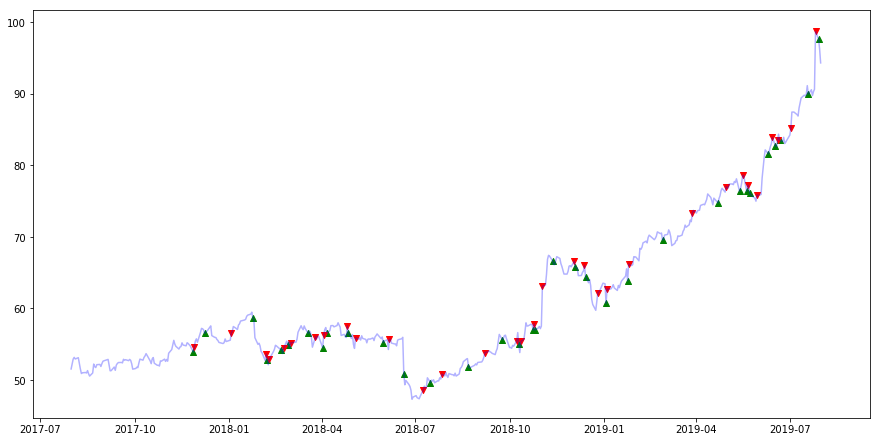

In [21]:
tst = NwStrat(10000,'SBUX', '2017-08-01', '2019-07-31',75)
tst._processing()
tst._run_strat()
tst._plot()
tst._return_stats()
tst._strat_eff()
print(np.nansum(tst.df.Profit))